<h1>Project: Implement a simple multilayer perceptron</h1>

<h3>Python Initialization</h3>

In [1]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from scipy.io import loadmat

<h3>Visualizing Data</h3>

<p>Generate a simple 1-dimensional toy dataset by calling <code>generate_data</code>. This function returns the data $\mathbf{X}$ and label $\mathbf{y}$. Note that $X$ is of shape (N, 2). We append 1 to each example to introduce bias.</p>

In [2]:
def ground_truth(x):
    return (x**2 + 10 * np.sin(x))

In [3]:
def generate_data():
    x = np.arange(0, 5, 0.1)
    y = ground_truth(x)
    x2d = np.concatenate([x, np.ones(x.shape)]).reshape(2, -1).T
    
    return x2d, y

In [4]:
X, y = generate_data()

print(f'The shape of X is {X.shape}. This is because we append 1 to each feature vector to introduce bias!')

The shape of X is (50, 2). This is because we append 1 to each feature vector to introduce bias!


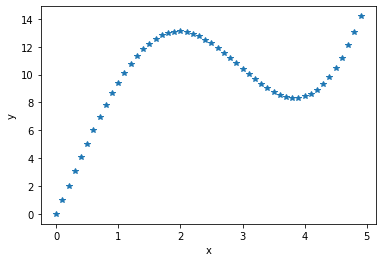

In [5]:
plt.plot(X[:,0], y, '*')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<h2>Multilayer Perceptron</h2>

<h3>Part Zero: Transition Function and Transition Function's gradient</h3>

<p>Transition functions are the key component of a neural network that contributes to its nonlinearity. For our neural network, we are going to use the ReLU transition function. Recall that the ReLU transition is as follows:</p>
$$\sigma(z) = \max(z, 0)$$

In [6]:
def ReLU(z):
    return np.maximum(z,0)

In [7]:
def ReLU_grad(z):
    return (z > 0).astype('float64')

<h3>Visualize the Activation Function</h3>

We can now visualize the activation function in the plot above by running the code in the cell below.

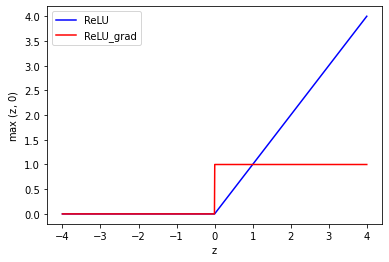

In [8]:
plt.plot(np.linspace(-4, 4, 1000), ReLU(np.linspace(-4, 4, 1000)), 'b-')
plt.plot(np.linspace(-4, 4, 1000), ReLU_grad(np.linspace(-4, 4, 1000)), 'r-')
plt.xlabel('z');
plt.ylabel(r'$\max$ (z, 0)');
plt.legend(['ReLU', 'ReLU_grad']);

We can also display the function and its gradient on a small example vector:

In [9]:
x = np.array([2.7,-0.5,-3.2])

print('X:', x)
print('ReLU(X):', ReLU(x))
print('ReLU_grad(X):', ReLU_grad(x))

X: [ 2.7 -0.5 -3.2]
ReLU(X): [2.7 0.  0. ]
ReLU_grad(X): [1. 0. 0.]


<h3>Part One: Forward Pass</h3>

In this section, implement the forward pass function <code>forward_pass(W, xTr)</code>. Note that $\mathbf{W}$ specifies the weights of the network at each layer. More specifically, $W[0]$ stores the weights for the first layer of the network, $W[i]$ stores the weights of the (i + 1)-th layer and $W[l-1]$ stores the weights of the last layer.

Each layer of the network produces two outputs, $A[i + 1]$ and $Z[i + 1]$, where

$$A[i + 1]=Z[i] * W[i]$$ 
for $i = 0, 1, 2, ..., l-1$ and 
$$Z[i+1]=\sigma(A[i+1])$$ for $i = 0, 1, 2, ..., l-2$ and 
$$Z[l-1]=A[l-1]$$

Here, $*$ stands for matrix multiplication and $Z[0], A[0]$ are both initialized to be the the training set.

For simplicity, we did not include bias when calculating $A[i + 1]$. For the purpose of this assignment, this is fine since we have appended one in all the raw features and our dataset is rather simple. In general, bias should always be included when calculating $A[i + 1]$

To visualize the variables `A`, `Z`, and `W` a bit better, consider the following hypothetical neural net layer:
![nnlayer.png](../references/nnlayer.png)

It is important to note that `W[i]` is an *array of matrices*, as specified in the docstring for the provided method `initweights`. Since layer `i` has 2 nodes and layer `i+1` has 3, `W[i]` is a 2 by 3 matrix.

Additionally, $\sigma$ is applied elementwise to the values in `A[i+1]`, and is `ReLU` for this assignment. The final output at the end of the neural network should be `Z[l]`.

The following function will allow you to randomly generate initial weights for the neural network:

In [10]:
def initweights(specs):
    W = []
    for i in range(len(specs) - 1):
        W.append(np.random.randn(specs[i], specs[i+1]))
        
    return W

In [11]:
# Initialize network weights
W = initweights([2, 3, 1])

In the cell below, we implement the forward pass function <code>forward_pass(W, xTr)</code>. The below is the pseudocode from the READ module:

![fwdpass.png](../references/fwdpass.png)

<h3>Important</h3>

A forward pass is used to evaluate a neural network on an input. However, here, we want to do a forward pass also to train a neural network, i.e. we will follow it with a backward pass. Therefore, unlike the pseudocode from the READ module, our code requires two changes. We output `A` (a <b>list</b> of the outputs at each layer after multiplying by the weights) and `Z` (a <b>list</b> of all outputs at each layer after passing the results of `A` through our transition function). To be precise, the outputs to our function should be $A=[a_1,a_2,\dots,a_L]$ and $Z=[z_1,z_2,\dots,z_L]$. The reason we need these intermediate results is that it is much more efficient to not recompute them when we use them during the back-prop pass.

In [12]:
def forward_pass(W, X_train):
    # Initialize A and Z
    A = [X_train]
    Z = [X_train]
    
    L = len(W)
    for l in range(L):
        a = Z[l] @ W[l]
        A.append(a)
        if l < L - 1:
            z = ReLU(a)
        else:
            z = a
        Z.append(z)
    
    return A, Z

<h3>Part Two: MSE Loss and Gradient</h3>

<h4>Loss Function</h4>

In this section, we implement the Mean Squared Error (MSE) loss function for regression. Recall that for a set of training example $\{(\mathbf{x}_1, y_1), ..., (\mathbf{x}_n, y_n)\}$, the MSE of the network $h$ is:

$$L = \frac{1}{n} \sum_{i = 1} ^n(h(\mathbf{x}_i) - y_i)^2$$

The <code>MSE</code> function takes the output of the network (<code>out</code>) and the training labels (<code>y</code>) and computes the MSE loss. <code>MSE_grad</code> function calculates the gradient of the MSE loss with respect to each entry of `out`. This function will be useful for backpropagation.

In [13]:
def MSE(out, y):
    n = len(y)
    loss = np.mean(np.power(out - y, 2))
    
    return loss

### Gradient

Now we need to implement the gradient of the MSE loss calculated above. When you take the derivative of the above with respect to the entries of out, you get the following:

$$\nabla L = \frac{2}{n} * (h(\mathbf{x}_i) - y_i)$$

In [14]:
def MSE_grad(out, y):
    n = len(y)
    grad = np.zeros(n)
    for i in range(n):
        grad[i] = (2 / n) * (out[i] - y[i])
        
    return grad

<h3> Part Three: Backpropagation</h3>

In this section, we implement the <code>backprop</code> for a ReLU network specified by the weight <code>W</code>. To recap, this is the stage that updates all the weights in the network starting from the last layer.

Again, our implementation will have slight tweaks from the one in the READ module on back propagation.

* Recall that in backpropagation, we alternate between calculating a "link" ( $\frac{\partial \mathcal L}{\partial \mathbf a_\ell}$) and updating the weight ($\mathbf W_\ell = \mathbf W_\ell -\alpha \frac{\partial \mathcal L}{\partial \mathbf W_\ell}$). In this function, we only calculate the update $\frac{\partial \mathcal L}{\partial \mathbf W_\ell}$, **without applying it**. In other words, we store all the $\frac{\partial \mathcal L}{\partial \mathbf W_\ell}$ for all $1 \le \ell \le L$, and return them all in the list `gradients`.

* We have absorbed $b$ into $\mathbf W$, so we don't need to calculate its gradient explicitly (thus, we should just ignore the second line in the for loop of the pseudocode!)

* In our code `delta` = $\vec \delta _ \ell = \frac{\partial \mathcal L}{\partial \mathbf a_\ell}$. The line initializing it has been done, so we only need to implement the for loop from the pseudocode (copied below).

![backpass.png](../references/backpass.png)

In [15]:
def backprop(W, A, Z, y):
    # Convert delta to a row vector to make things easier
    delta = (MSE_grad(Z[-1].flatten(), y) * 1).reshape(-1, 1)
    
    # compute gradient with backprop
    gradients = []
    L = len(W)
    for l in range(L-1, -1, -1):
        gradients.append(Z[l].T @ delta)
        delta = ReLU_grad(A[l]) * (delta @ W[l].T)
        
    gradients = gradients[::-1]
    
    return gradients

<h3>Part Four: Training with Gradient Descent</h3>

Run the cell below to train a ReLU Network for the task with Gradient Descent. Feel free to play around with the hyperparameters such learning rate, number of epochs, number of hidden layers, size of each hidden layers.

In [16]:
def plot_results(x, y, Z, losses):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(12)
    fig.set_figheight(8)
    
    ax[0].plot(x, y)
    ax[0].plot(x, Z[-1].flatten())
    ax[0].set_ylabel('$f(x)$');
    ax[0].set_xlabel('$x$');
    ax[0].legend(['Actual', 'Predicted']);
    
    ax[1].semilogy(losses)
    ax[1].title.set_text('Loss');
    ax[1].set_xlabel('Epoch');
    
    plt.show()

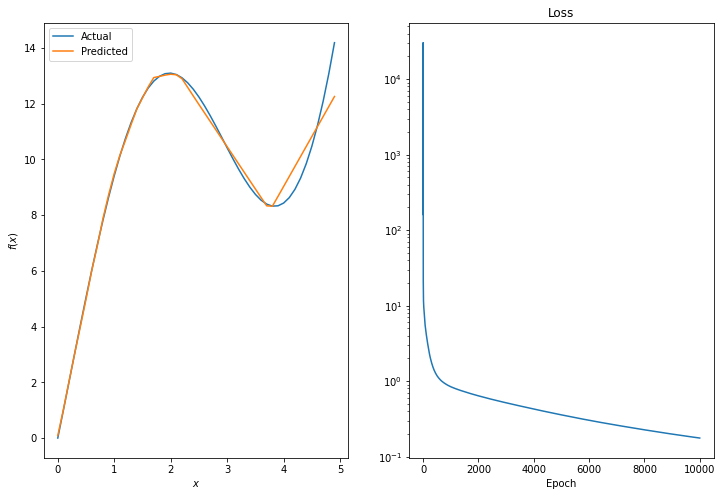

In [17]:
# generate data
X, y = generate_data()

# learning rate for Gradient Descent
lr = 0.001

# Number of epochs
# one epoch - one full pass through the dataset
M = 10000

# keep track of the losses
losses = np.zeros(M)

# initialize a neural network with one hidden layer
# Try varying the depth and width of the neural networks to see the effect
W = initweights([2, 200, 1])

# Start training
for i in range(M):
    
    # Do a forward pass
    A, Z = forward_pass(W, X)
    
    # Calculate the loss
    losses[i] = MSE(Z[-1].flatten(), y)
    
    # Calculate the gradients using backprop
    gradients = backprop(W, A, Z, y)
    
    # Update the parameters
    for j in range(len(W)):
        W[j] -= lr * gradients[j]
        
plot_results(X[:, 0], y, Z, losses)